Matplotlib is building the font cache; this may take a moment.


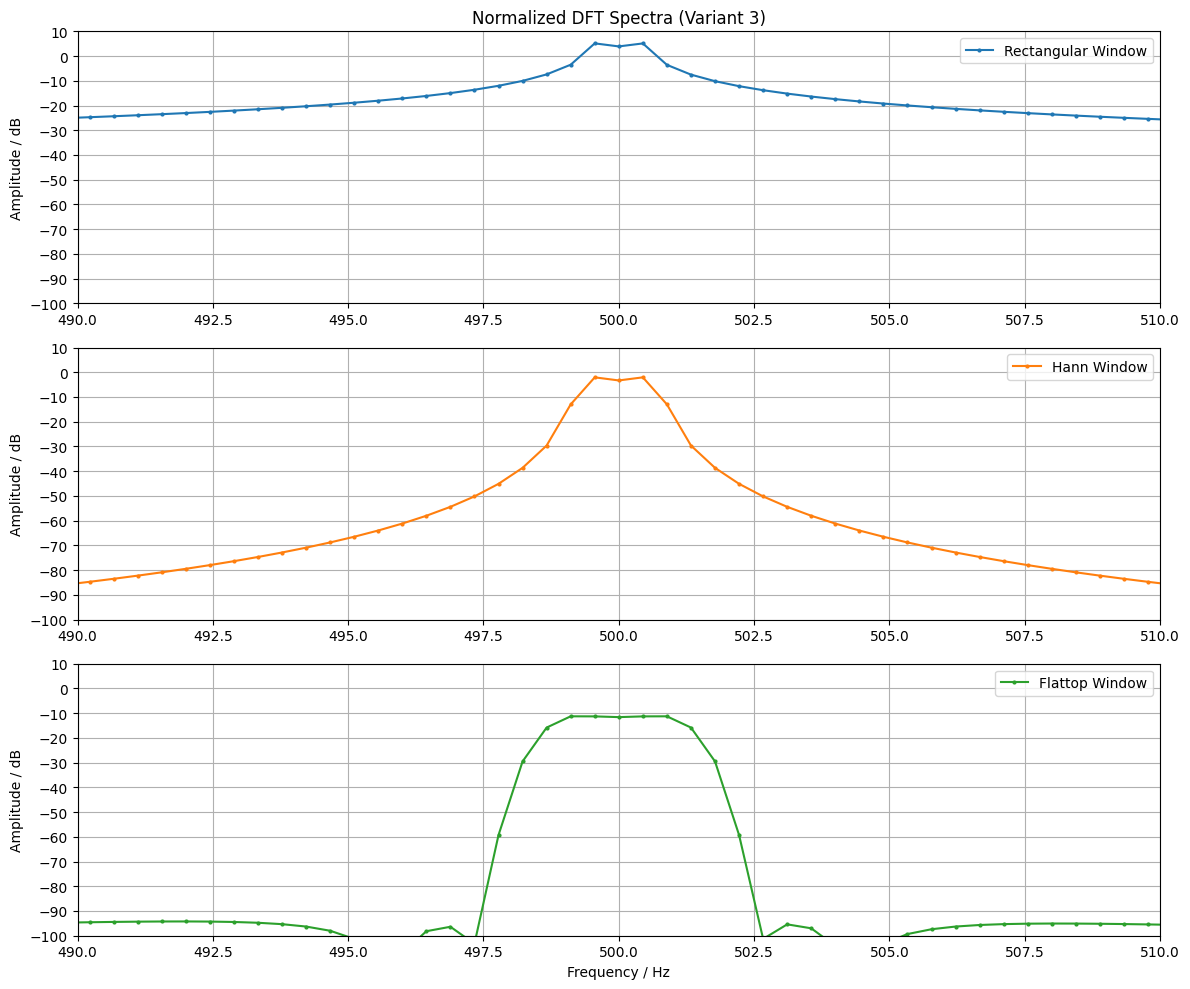

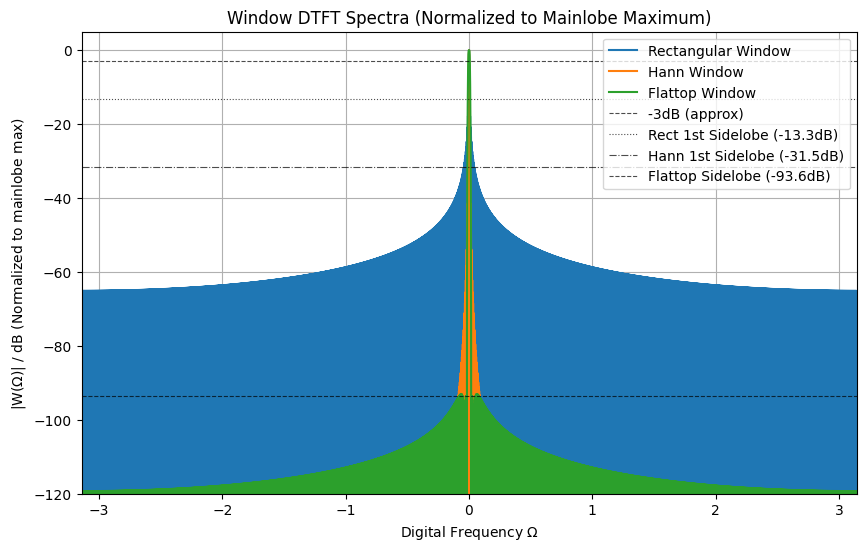

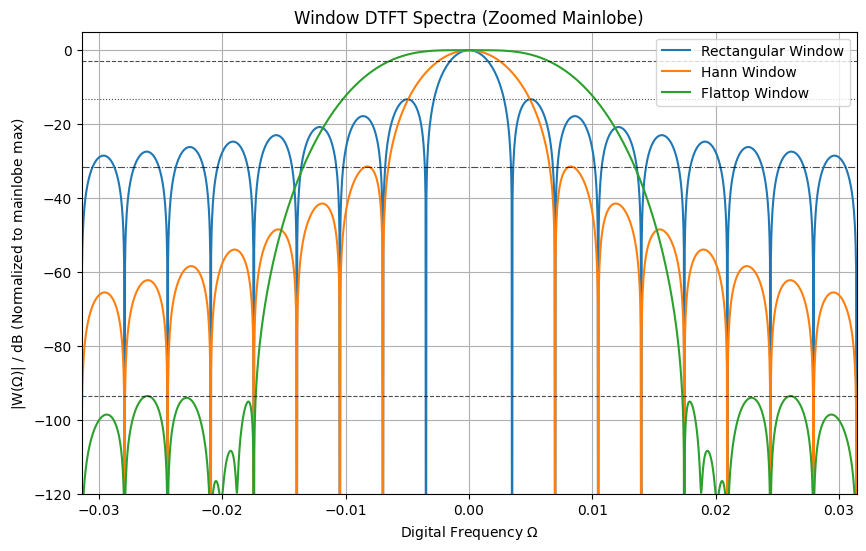

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, fftshift
from scipy.signal.windows import hann, flattop


f1 = 500.0  # Hz
f2 = 500.25 # Hz
f3 = 499.75 # Hz
amplitude = 2.0 # Amplitude |x[k]|max
fs = 800.0  # Hz (Sampling frequency)
N = 1800    # Number of samples

# --- 3. Generating Signals ---
k = np.arange(N)
x1 = amplitude * np.sin(2 * np.pi * f1 / fs * k)
x2 = amplitude * np.sin(2 * np.pi * f2 / fs * k)
x3 = amplitude * np.sin(2 * np.pi * f3 / fs * k)

# Combined signal (sum of the three sines)
x_total = x1 + x2 + x3

# --- 4. Generating Windows ---
wrect = np.ones(N)                  # Rectangular window
whann = hann(N, sym=False)          # Hann window
wflattop = flattop(N, sym=False)    # Flattop window

# (Optional: Plotting the windows, as suggested in Section 4)
# plt.figure(figsize=(10, 4))
# plt.plot(wrect, 'C0o-', ms=3, label='rect')
# plt.plot(whann, 'C1o-', ms=3, label='hann')
# plt.plot(wflattop, 'C2o-', ms=3, label='flattop')
# plt.xlabel(r'$k$')
# plt.ylabel(r'window_$w[k]$')
# plt.xlim(0, N)
# plt.legend()
# plt.title('Generated Window Signals')
# plt.grid(True)
# plt.show()


# --- 5. DFT spectra using FFT algorithm ---

# 5.1. "Normalized" level of DFT within the interval
def fft2db(X):
    """
    Normalizes FFT magnitude to sine signal amplitudes in dB.
    Handles DC (0 Hz) and Nyquist (fs/2) bins correctly.
    """
    N_fft = X.size
    # Normalization to sine amplitudes (2/N)
    Xtmp = 2 / N_fft * np.abs(X)
    
    # Adjust DC (0 Hz) bin: exists only once, so cancel *2 from above
    Xtmp[0] *= 0.5 
    
    # Adjust Nyquist (fs/2) bin (if N_fft is even): exists only once
    if N_fft % 2 == 0: 
        Xtmp[N_fft // 2] *= 0.5
        
    # Convert to dB
    return 20 * np.log10(Xtmp + 1e-10) # Add small epsilon to avoid log(0)


# Calculate FFT for the combined signal with each window
X_rect = fft(x_total * wrect)
X_hann = fft(x_total * whann)
X_flattop = fft(x_total * wflattop)

# Set up frequency vector
df = fs / N
f = np.arange(N) * df

# --- Plot 1: Normalized DFT Spectra ---
plt.figure(figsize=(12, 10)) # Adjusted figure size for better readability

# Rectangular Window
plt.subplot(3, 1, 1)
plt.plot(f, fft2db(X_rect), 'C0o-', ms=2, label='Rectangular Window')
plt.xlim(490, 510) # Zoomed interval around signal frequencies
plt.ylim(-100, 10)  # Amplitude 2 is 6dB, so set y-limits accordingly
plt.xticks(np.arange(490, 511, 2.5))
plt.yticks(np.arange(-100, 11, 10))
plt.legend()
plt.ylabel('Amplitude / dB')
plt.title('Normalized DFT Spectra (Variant 3)')
plt.grid(True)

# Hann Window
plt.subplot(3, 1, 2)
plt.plot(f, fft2db(X_hann), 'C1o-', ms=2, label='Hann Window')
plt.xlim(490, 510)
plt.ylim(-100, 10)
plt.xticks(np.arange(490, 511, 2.5))
plt.yticks(np.arange(-100, 11, 10))
plt.legend()
plt.ylabel('Amplitude / dB')
plt.grid(True)

# Flattop Window
plt.subplot(3, 1, 3)
plt.plot(f, fft2db(X_flattop), 'C2o-', ms=2, label='Flattop Window')
plt.xlim(490, 510)
plt.ylim(-100, 10)
plt.xticks(np.arange(490, 511, 2.5))
plt.yticks(np.arange(-100, 11, 10))
plt.legend()
plt.xlabel('Frequency / Hz')
plt.ylabel('Amplitude / dB')
plt.grid(True)

plt.tight_layout()
plt.show()


# --- 5.2. Window DTFT spectra normalized to their mainlobe maximum ---

def winDTFTdB(w):
    """
    Calculates the DTFT-like spectrum of a window, normalized to its maximum, in dB.
    Uses zero-padding and fftshift.
    """
    N_win = w.size       # get window length
    Nz = 100 * N_win     # zeropadding length for high resolution
    W_padded = np.zeros(Nz, dtype=complex) # allocate RAM
    W_padded[0:N_win] = w # insert window
    
    # FFT, fftshift, and magnitude
    W_dtft_mag = np.abs(fftshift(fft(W_padded)))
    
    # Normalize to maximum (i.e., mainlobe peak becomes 0 dB)
    W_dtft_normalized = W_dtft_mag / np.max(W_dtft_mag)
    
    # Convert to dB
    W_dtft_db = 20 * np.log10(W_dtft_normalized + 1e-10) # Add small epsilon
    
    # Get appropriate digital frequencies (shifted from -pi to pi)
    Omega = 2 * np.pi / Nz * np.arange(Nz) - np.pi 
    
    return Omega, W_dtft_db

# Calculate DTFT spectra for each window
Omega_rect, W_rect_dtft = winDTFTdB(wrect)
Omega_hann, W_hann_dtft = winDTFTdB(whann)
Omega_flattop, W_flattop_dtft = winDTFTdB(wflattop)

# --- Plot 2: Window DTFT Spectra ---
plt.figure(figsize=(10, 6))

plt.plot(Omega_rect, W_rect_dtft, label='Rectangular Window')
plt.plot(Omega_hann, W_hann_dtft, label='Hann Window')
plt.plot(Omega_flattop, W_flattop_dtft, label='Flattop Window')

# Plotting reference lines for mainlobe bandwidth and sidelobe levels (approximate for typical windows)
plt.plot([-np.pi, np.pi], [-3.01, -3.01], 'k--', linewidth=0.8, alpha=0.7, label='-3dB (approx)') # Mainlobe BW (for Rect)
plt.plot([-np.pi, np.pi], [-13.3, -13.3], 'k:', linewidth=0.8, alpha=0.7, label='Rect 1st Sidelobe (-13.3dB)')
plt.plot([-np.pi, np.pi], [-31.5, -31.5], 'k-.', linewidth=0.8, alpha=0.7, label='Hann 1st Sidelobe (-31.5dB)')
plt.plot([-np.pi, np.pi], [-93.6, -93.6], 'k--', linewidth=0.8, alpha=0.7, label='Flattop Sidelobe (-93.6dB)')

plt.xlim(-np.pi, np.pi) # Full range
plt.ylim(-120, 5)        # Zoomed amplitude range
plt.xlabel(r'Digital Frequency $\Omega$')
plt.ylabel(r'|W($\Omega$)| / dB (Normalized to mainlobe max)')
plt.title('Window DTFT Spectra (Normalized to Mainlobe Maximum)')
plt.legend()
plt.grid(True)
plt.show()

# --- Plot 2 (Zoomed): Window DTFT Spectra (Mainlobe detail) ---
plt.figure(figsize=(10, 6))

plt.plot(Omega_rect, W_rect_dtft, label='Rectangular Window')
plt.plot(Omega_hann, W_hann_dtft, label='Hann Window')
plt.plot(Omega_flattop, W_flattop_dtft, label='Flattop Window')

# Plotting reference lines again for context
plt.plot([-np.pi/100, np.pi/100], [-3.01, -3.01], 'k--', linewidth=0.8, alpha=0.7) 
plt.plot([-np.pi/100, np.pi/100], [-13.3, -13.3], 'k:', linewidth=0.8, alpha=0.7)
plt.plot([-np.pi/100, np.pi/100], [-31.5, -31.5], 'k-.', linewidth=0.8, alpha=0.7)
plt.plot([-np.pi/100, np.pi/100], [-93.6, -93.6], 'k--', linewidth=0.8, alpha=0.7)

plt.xlim(-np.pi / 100, np.pi / 100) # Zoom into mainlobe
plt.ylim(-120, 5)
plt.xlabel(r'Digital Frequency $\Omega$')
plt.ylabel(r'|W($\Omega$)| / dB (Normalized to mainlobe max)')
plt.title('Window DTFT Spectra (Zoomed Mainlobe)')
plt.legend()
plt.grid(True)
plt.show()

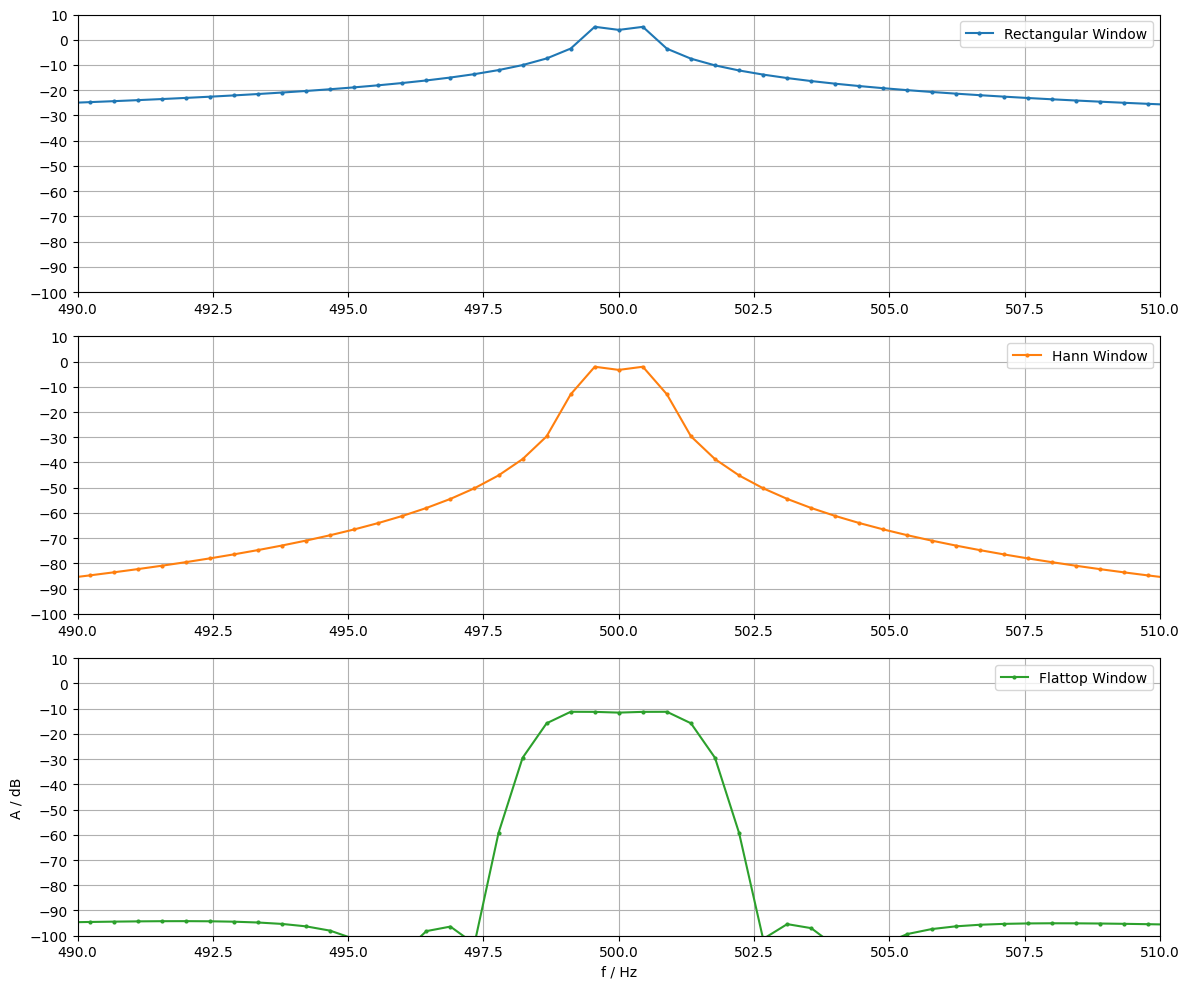

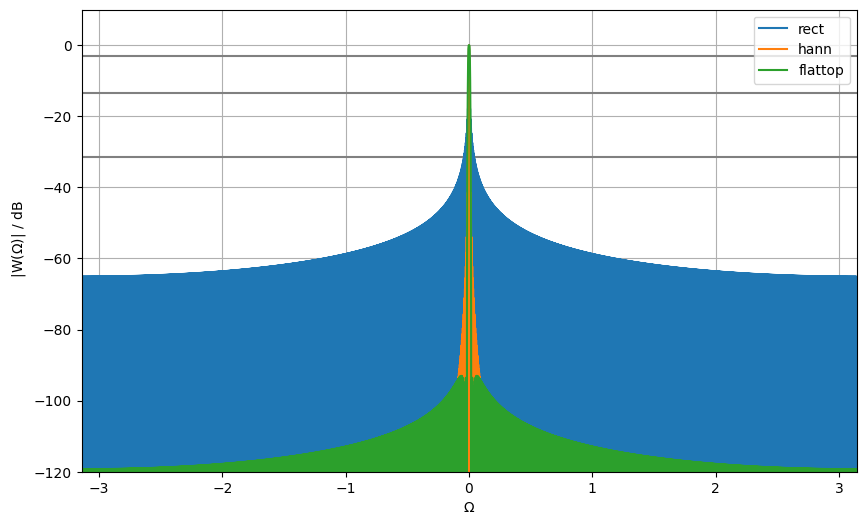

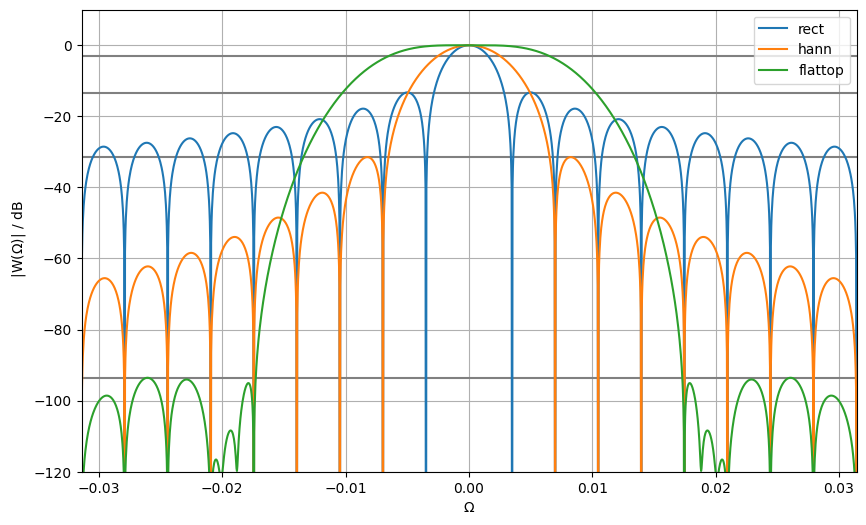

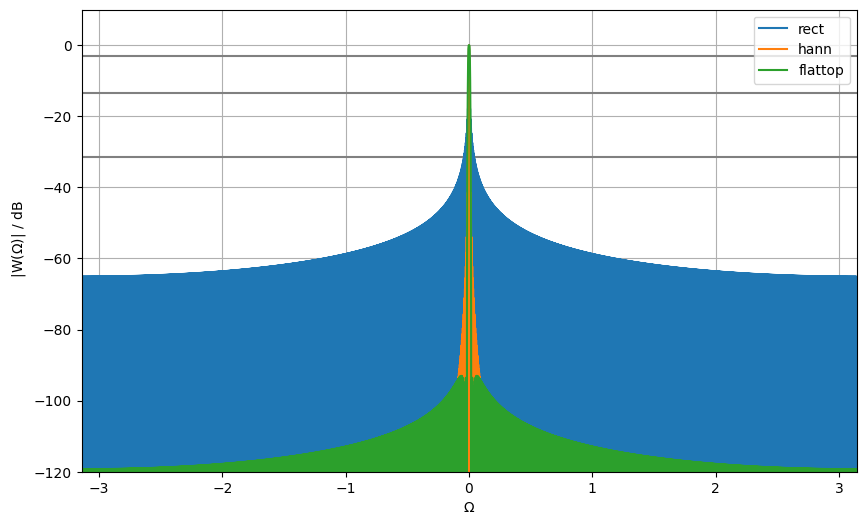

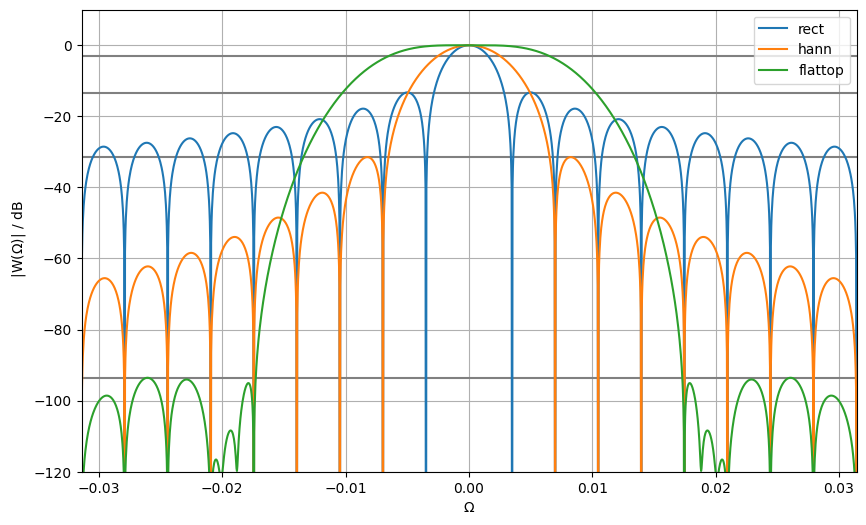

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft, ifft, fftshift
#from scipy.fft import fft, ifft, fftshift
from scipy.signal.windows import hann, flattop

f1 = 500.0
f2 = 500.25
f3 = 499.75
amplitude = 2.0
fs = 800.0
N = 1800

# 3. Generating Signals
k = np.arange(N)
x1 = amplitude * np.sin(2 * np.pi * f1 / fs * k)
x2 = amplitude * np.sin(2 * np.pi * f2 / fs * k)
x3 = amplitude * np.sin(2 * np.pi * f3 / fs * k)

x_total = x1 + x2 + x3

# 4. Generating Windows
wrect = np.ones(N)
whann = hann(N, sym=False)
wflattop = flattop(N, sym=False)

# 5. DFT spectra using FFT algorithm

# 5.1. "Normalized" level of DFT within the interval
# this handling is working for N even and odd:
def fft2db (X) :
    N_fft = X.size
    Xtmp = 2/N_fft * np.abs(X) # independent of N, norm for sine amplitudes
    Xtmp[0] *= 1/2 # bin for f=0 Hz is existing only once,
    #so cancel *2 from above
    if N_fft % 2 == 0: #fs/2 is included as a bin
        # fs/2 bin is existing only once, SO cancel *2 from above
        Xtmp[N_fft//2] *= 1/2
    return 20*np.log10(Xtmp + 1e-10) # in dB

# setup of frequency vector this way is independent of N even/odd:
df = fs / N
f = np.arange(N) * df

X_rect = fft(x_total * wrect)
X_hann = fft(x_total * whann)
X_flattop = fft(x_total * wflattop)

plt.figure(figsize=(12, 10))

plt.subplot(3, 1, 1)
plt.plot(f, fft2db(X_rect), 'C0o-', ms=2, label='Rectangular Window')
plt.xlim(490, 510)
plt.ylim(-100, 10)
plt.xticks(np.arange(490, 511, 2.5))
plt.yticks(np.arange(-100, 11, 10))
plt.legend()
#plt.xlabel('f / Hz')
#plt.ylabel('A / dB')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(f, fft2db(X_hann), 'C1o-', ms=2, label='Hann Window')
plt.xlim(490, 510)
plt.ylim(-100, 10)
plt.xticks(np.arange(490, 511, 2.5))
plt.yticks(np.arange(-100, 11, 10))
plt.legend()
#plt.xlabel('f / Hz')
#plt.ylabel('A / dB')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(f, fft2db(X_flattop), 'C2o-', ms=2, label='Flattop Window')
plt.xlim(490, 510)
plt.ylim(-100, 10)
plt.xticks(np.arange(490, 511, 2.5))
plt.yticks(np.arange(-100, 11, 10))
plt.legend()
plt.xlabel('f / Hz')
plt.ylabel('A / dB')
plt.grid(True)

plt.tight_layout()
plt.show()

# 5.2. Window DTFT spectra normalized to their mainlobe maximum
def winDTFTdB(w):
    N_win = w.size       # get window length
    Nz = 100 * N_win     # zeropadding length
    W_padded = np.zeros(Nz, dtype=complex) # allocate RAM
    W_padded[0:N_win] = w # insert window
    
    W_dtft_mag = np.abs(fftshift(fft(W_padded))) # fft, fftshift and magnitude
    
    W_dtft_normalized = W_dtft_mag / np.max(W_dtft_mag) # normalize to maximum, i.e. the mainlobe
    
    W_dtft_db = 20 * np.log10(W_dtft_normalized + 1e-10) # get level in dB
    
    Omega = 2 * np.pi / Nz * np.arange(Nz) - np.pi # get appropriate digital frequencies # also shifted
    
    return Omega, W_dtft_db

Omega_rect, W_rect_dtft = winDTFTdB(wrect)
Omega_hann, W_hann_dtft = winDTFTdB(whann)
Omega_flattop, W_flattop_dtft = winDTFTdB(wflattop)

plt.figure(figsize=(10, 6))

plt.plot([-np.pi, +np.pi], [-3.01, -3.01], 'gray')# mainlobe bandwidth
plt.plot([-np.pi, +np.pi], [-13.3, -13.3], 'gray')# rect max sidelobe
plt.plot([-np.pi, +np.pi], [-31.5, -31.5], 'gray')# hann max sidelobe
plt.plot([-np.pi, +np.pi],[-93.6, -93.6], 'gray')# flattop max
#sidelobe

plt.plot(Omega_rect, W_rect_dtft, label='rect')
plt.plot(Omega_hann, W_hann_dtft, label='hann')
plt.plot(Omega_flattop, W_flattop_dtft, label='flattop')

plt.xlim(-np.pi, np.pi)
plt.ylim(-120, 10)
plt.xlabel(r'$\Omega$')
plt.ylabel(r' |W($\Omega$)| / dB')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

plt.plot([-np.pi/100, np.pi/100], [-3.01, -3.01], 'gray')
plt.plot([-np.pi/100, np.pi/100], [-13.3, -13.3], 'gray')
plt.plot([-np.pi/100, np.pi/100], [-31.5, -31.5], 'gray')
plt.plot([-np.pi/100, np.pi/100],[-93.6, -93.6], 'gray')

plt.plot(Omega_rect, W_rect_dtft, label='rect')
plt.plot(Omega_hann, W_hann_dtft, label='hann')
plt.plot(Omega_flattop, W_flattop_dtft, label='flattop')

plt.xlim(-np.pi / 100, np.pi / 100) # zoom into mainlobe
plt.ylim(-120, 10)
plt.xlabel(r'$\Omega$')
plt.ylabel(r' |W($\Omega$)| / dB')
plt.legend()
plt.grid(True)
plt.show()